In [2]:
import xarray as xr
from osgeo import gdal,osr
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import numpy as np
import numpy.ma as ma
import rasterio
from rasterio.plot import show


In [3]:
path = 'D:\\3_DataViz\\2_glaciers\\0_Antartica\\'
ncdf_src = 'antarctic_ice_vel_phase_map_v01.nc'

ds = xr.open_dataset(path + ncdf_src)

In [3]:
ds.values()
# https://towardsdatascience.com/handling-netcdf-files-using-xarray-for-absolute-beginners-111a8ab4463f

ValuesView(<xarray.Dataset>
Dimensions:       (x: 12445, y: 12445)
Coordinates:
  * x             (x) float64 -2.8e+06 -2.8e+06 -2.799e+06 ... 2.799e+06 2.8e+06
  * y             (y) float64 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
    lat           (y, x) float64 ...
    lon           (y, x) float64 ...
Data variables:
    coord_system  |S1 ...
    VX            (y, x) float32 ...
    VY            (y, x) float32 ...
    STDX          (y, x) float32 ...
    STDY          (y, x) float32 ...
    ERRX          (y, x) float32 ...
    ERRY          (y, x) float32 ...
    CNT           (y, x) int32 ...
    SOURCE        (y, x) int8 ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    p

In [4]:
# Explore the netcdf

#ds.keys()
#ds.attrs
ds.var()
#ds.VX.dims
#ds.thickness.coords
#ds.thickness.coords['x']

<xarray.Dataset>
Dimensions:  ()
Data variables:
    VX       float32 1.185e+04
    VY       float32 2.769e+04
    STDX     float32 63.44
    STDY     float32 43.54
    ERRX     float32 nan
    ERRY     float32 nan
    CNT      float64 2.978e+10
    SOURCE   float64 1.03

In [5]:
# Extract data as a numpy array
arr = np.sqrt(np.square(ds.VX.data)+np.square(ds.VY.data))
arr = np.nan_to_num(arr,nan=99999)
arr_ma = np.ma.masked_where(arr == 99999, arr, copy=True)
#create a mask to reshape rgb_ds for the 4 bands
mask = np.ma.getmask(arr_ma)
arr_ma = np.where(arr_ma<1,1,arr_ma)
arr_ma = np.ma.masked_where(mask, arr_ma)

In [6]:
np.amax(arr_ma)

4218.265

In [7]:

# Scale the velocities by the log of the data.
d = np.log(arr_ma)
# Rescaling (min-max normalization) - 255 for RGB ??
scaled_ds = (255*(d - np.amin(d))/np.ptp(d)).astype(np.uint8)

#avoid 0 values
scaled_ds = np.where(scaled_ds == 0 ,1 ,scaled_ds)
scaled_ds = np.ma.masked_where(mask, scaled_ds)

In [8]:
# Construct a colormap with log scale 
# designed by Terry Haran, NSIDC, April 2018. 
# Construct an RGB table using a log scale between 1 and 500 m/year.
vel = np.exp(np.linspace(np.log(1), np.log(500), num=256)) 
hue = np.arange(256) / 255.0 
sat = np.clip(1. / 3 + vel / 187.5, 0, 1) 
value = np.zeros(256) + 0.75 
hsv = np.stack((hue, sat, value), axis=1) 
rgb = colors.hsv_to_rgb(hsv) 
# Be sure the first color (the background) is white
rgb[0, :] = 1
# Create the colormap 
cmap = colors.ListedColormap(rgb, name='velocity')
print(type(cmap))

<class 'matplotlib.colors.ListedColormap'>


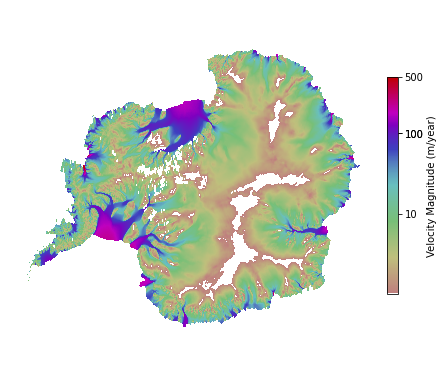

In [9]:
plt.figure(figsize=(8,8))
fig = plt.imshow(scaled_ds, origin='lower',cmap=cmap)
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
tickval = [1, 10, 100, 100, 500]
t = np.log(tickval)
cb = plt.colorbar(fig, ticks=255*(t - t[0])/(t[-1] - t[0]), shrink=0.5)
cb.set_label('Velocity Magnitude (m/year)')
cb.ax.set_yticklabels(tickval)
plt.show()

In [10]:
dataset = scaled_ds
with rasterio.open(
    path+'scaled_ds.tif',
    'w',
    driver='GTiff',
    height=dataset.shape[0],
    width=dataset.shape[1],
    count=1,
    dtype=dataset.dtype,
    crs='+proj=latlong'
) as dst:
    dst.write(dataset, 1)

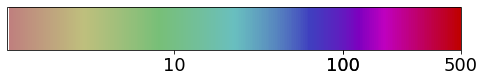

In [11]:
plt.figure(figsize=(9, 1.5))
img = plt.imshow(scaled_ds, cmap=cmap)
plt.gca().set_visible(False)
cax = plt.axes([0,0, 0.7, 0.4])
tickval = [1, 10, 100, 100, 500]
t = np.log(tickval)
cb = plt.colorbar(fig, ticks=255*(t - t[0])/(t[-1] - t[0]), shrink=0.5,cax=cax, orientation="horizontal")
cb.ax.set_xticklabels(tickval)
cb.ax.tick_params(labelsize=18)
plt.savefig("D:\\3_DataViz\\2_glaciers\\10_images\\colorbar_velocity.png")

In [12]:
# apply the colormap to the scaled data
rgb_ds = cmap(scaled_ds.data)
mask2 = np.stack([mask,mask,mask,mask],axis=2)
rgb_ds = np.ma.masked_where(mask2, rgb_ds)

# Scale RGB values from [0,1] to [0,255]
data_array_scaled = np.interp(rgb_ds,(0, 1), (0, 255))
# Round to the nearest bigger integer
data_array_scaled = np.ceil(data_array_scaled)
data_array_scaled = data_array_scaled.astype(int)
data_array_scaled = np.ma.masked_where(mask2, data_array_scaled)

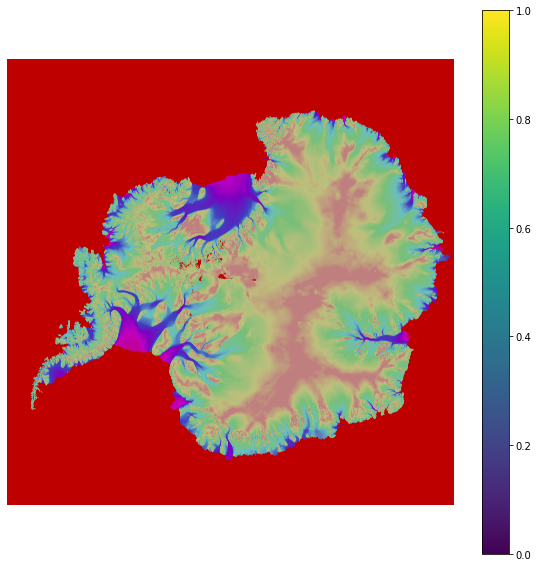

In [13]:
plt.figure(figsize=(10,10))
fig = plt.imshow(rgb_ds, origin='lower')
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
cb = plt.colorbar(fig)
plt.show()

# New Geotiff properties  

originX = top left coord - ```ds.thickness.coords['x'][0].data```

originY = top left coord - ```ds.thickness.coords['y'][0].data```

```pixelWidth = ds.thickness.coords['x'].data[1]- ds.thickness.coords['x'].data[0]```

```pixelHeight = ds.thickness.coords['y'].data[1]- ds.thickness.coords['y'].data[0]```


Number of bands = 3 (RGB) : ```bands = data_array_scaled.shape[2]-1```


Size in x direction: ```rows = ds.thickness.data.shape[1]```

Size in y direction: ```cols = ds.thickness.data.shape[0]```


In [14]:
print(ds.VX.coords)
print(ds.VX.data.shape)

Coordinates:
  * x        (x) float64 -2.8e+06 -2.8e+06 -2.799e+06 ... 2.799e+06 2.8e+06
  * y        (y) float64 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
(12445, 12445)


In [15]:
print(ds.VX.coords['x'][0].data)
print(ds.VX.coords['y'][0].data )
print(ds.VX.coords['x'].data[1]- ds.VX.coords['x'].data[0])
print(ds.VX.coords['y'].data[1]- ds.VX.coords['y'].data[0])
print(data_array_scaled.shape[2]-1)
print(ds.VX.data.shape[1])
print(ds.VX.data.shape[0])

-2800000.0
2800000.0
450.0
-450.0
3
12445
12445


In [16]:
# Creates a copy of a 3-band raster with values from array'''
# GeoTIFF creation options : https://gdal.org/drivers/raster/gtiff.html

# Destination file name 
out_path = 'D:\\3_DataViz\\2_glaciers\\0_Antartica\\'
file_name = 'antarctica_velocity.tif'
dest_name = out_path + file_name

# info from source
originX = ds.VX.coords['x'][0].data
originY = ds.VX.coords['y'][0].data 
pixelWidth = ds.VX.coords['x'].data[1]- ds.VX.coords['x'].data[0]
pixelHeight = ds.VX.coords['y'].data[1]- ds.VX.coords['y'].data[0]
NumberOfBands = data_array_scaled.shape[2]-1
rows = ds.VX.data.shape[1]
cols = ds.VX.data.shape[0]

# Get geotiff driver
driver = gdal.GetDriverByName('GTiff')
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF','COMPRESS=LZW','PREDICTOR=2','GDAL_TIFF_INTERNAL_MASK=YES']

# Create new raster
dest = driver.Create(dest_name,rows,cols, NumberOfBands, eType=gdal.GDT_Byte,options=options)
dest.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

# Set metadata.SetGeoTransform(src.GetGeoTransform())
NODATA = 255
for band in range(NumberOfBands):
   dest.GetRasterBand(band+1).SetNoDataValue(NODATA)
   dest.GetRasterBand(band+1).WriteArray(data_array_scaled[:,:,band].filled(NODATA))


#Set the projection of the GeoTiff [same as source] ( 

destSRS = osr.SpatialReference()
destSRS.ImportFromProj4 ("+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs" )
dest.SetProjection(destSRS.ExportToWkt())

# Close datasets
#src = None
dest = None


In [5]:
# 1. add an alpha band to the RGB for transparent background in Mapbox
# 2. reprojection in web mercator (3857)
out_path = 'D:\\3_DataViz\\2_glaciers\\0_Antartica\\'
file_name = 'Antarctica_2020-07-15_v02_thickness_rgba_4326.tif'
src_file = out_path + file_name
out_file = file_name.replace('_4326.tif','_3857.tif')
dest_file = out_path + out_file

options = gdal.WarpOptions(format='GTiff', srcNodata=255, dstSRS='EPSG:3857', dstAlpha=True)
dest = gdal.Warp(dest_file, src_file, options=options)
print("Processing done for "+ out_file)
dest = None




Processing done for Antarctica_2020-07-15_v02_thickness_rgba_3857.tif


In [5]:
#3. creation du MBTiles

#mb_file = out_file.replace('.tif','.mbtiles')
out_path = 'D:\\3_DataViz\\2_glaciers\\0_Antartica\\'
dest_file= out_path +'Antarctica_2020-07-15_v02_thickness_rgba_3857_comp.tif'
mb_file ='Antarctica_2020-07-15_v02_thickness_rgba_3857_comp.mbtiles'
# Create the mbtiles files
creation_opt = ["TILE_FORMAT=PNG8","ZLEVEL=9"]
options = gdal.TranslateOptions(format = 'mbtiles')
gdal.Translate(destName=out_path+mb_file ,srcDS=dest_file, options = options,creationOptions= creation_opt)


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000020C412DD3C0> >

In [6]:

# Create the Zoom level [equivalent to gdaladdo with CLI]
Image = gdal.Open(out_path+'antarctica_velocity_rgba_3857.mbtiles', 1)  # 0 = read-only, 1 = read-write.
gdal.SetConfigOption('COMPRESS_OVERVIEW', 'LZW')
Image.BuildOverviews('CUBIC', [2, 4, 8, 16], gdal.TermProgress_nocb)
del Image  # close the dataset (Python object and pointers)
print("Tiles produced for "+ mb_file)

Tiles produced for Antarctica_2020-07-15_v02_thickness_rgba_3857.mbtiles
